In [20]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [21]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data_flatten.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [22]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_10/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.2326% 	9.00883% 	0.04888		0.04619		0.0		1.0	
(1024,256) 	95.4% 		0.46004% 	6.42186% 	0.82382		0.83052		0.0		0.98705	
(1024,1024) 	3.04% 		1.85077% 	2.31894% 	0.02452		0.00362		0.0		0.95211	


In [23]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 1.00000 1.00000 0.00000 	(213910, 0.9037879560274013) 0.92316 0.90379 0.01937 	(688427, 0.938751472320377) 0.01368 0.93875 0.92507 	
(32635, 1.0) 1.00000 1.00000 0.00000 	(212974, 0.8941978001127759) 0.90712 0.89420 0.01292 	(4240, 0.9623085983510011) 0.24800 0.96231 0.71431 	
(2436, 1.0) 0.98931 1.00000 0.01069 	(44828, 0.8401417658060423) 0.87922 0.84014 0.03908 	(694929, 0.9799764428739693) 0.02246 0.97998 0.95752 	
(55808, 1.0) 0.99647 1.00000 0.00353 	(232148, 0.8783613613364569) 0.88275 0.87836 0.00439 	(600540, 0.5747938751472321) 0.02171 0.57479 0.55309 	
(44159, 1.0) 0.99868 1.00000 0.00132 	(106790, 0.8420843224691953) 0.89155 0.84208 0.04947 	(226406, 0.8680800942285042) 0.07576 0.86808 0.79232 	
(25344, 1.0) 1.00000 1.00000 0.00000 	(155900, 0.8219974944514251) 0.84106 0.82200 0.01907 	(122896, 0.99528857

(2580, 1.0) 0.79853 1.00000 0.20147 	(81452, 0.9560840745164847) 0.94711 0.95608 0.00898 	(253066, 0.9646643109540636) 0.05410 0.96466 0.91057 	
(46219, 1.0) 1.00000 1.00000 0.00000 	(62612, 0.8908013524590833) 0.87786 0.89080 0.01294 	(146651, 0.9128386336866903) 0.07875 0.91284 0.83409 	
(58659, 1.0) 0.99321 1.00000 0.00679 	(118434, 0.9174479285497729) 0.85903 0.91745 0.05842 	(272646, 0.8138987043580682) 0.08118 0.81390 0.73272 	
(11156, 1.0) 0.99976 1.00000 0.00024 	(89238, 0.8931446765002358) 0.89666 0.89314 0.00352 	(483510, 0.9681978798586572) 0.07350 0.96820 0.89470 	
(8712, 1.0) 0.99998 1.00000 0.00002 	(222790, 0.8651861688749861) 0.89619 0.86519 0.03100 	(207996, 0.9316843345111897) 0.10233 0.93168 0.82935 	
(5655, 1.0) 0.85819 1.00000 0.14181 	(123902, 0.8427216030549833) 0.88202 0.84272 0.03930 	(465356, 1.0) 0.06378 1.00000 0.93622 	
(12302, 1.0) 0.99995 1.00000 0.00005 	(138808, 0.8876924220785591) 0.88043 0.88769 0.00727 	(101397, 0.8162544169611308) 0.27275 0.81625 0.

(68070, 1.0) 0.99999 1.00000 0.00001 	(13579, 0.7717501726755115) 0.39839 0.77175 0.37336 	(190691, 0.7856301531213193) 0.14094 0.78563 0.64469 	
(672, 1.0) 0.10333 1.00000 0.89667 	(203463, 0.8486464072366304) 0.86629 0.84865 0.01765 	(397756, 0.8928150765606597) 0.02388 0.89282 0.86893 	
(11903, 1.0) 0.99990 1.00000 0.00010 	(184233, 0.8349205207692031) 0.88657 0.83492 0.05165 	(1158, 0.009422850412249812) 0.23908 0.00942 0.22966 	
(80386, 1.0) 1.00000 1.00000 0.00000 	(81549, 0.9581239256984455) 0.95113 0.95812 0.00700 	(340263, 0.9988221436984688) 0.05625 0.99882 0.94258 	
(3839, 1.0) 0.87424 1.00000 0.12576 	(55978, 0.8054739150457626) 0.85869 0.80547 0.05322 	(727709, 0.7997644287396938) 0.00846 0.79976 0.79131 	
(15116, 1.0) 1.00000 1.00000 0.00000 	(24623, 0.855467495134205) 0.77309 0.85547 0.08238 	(15481, 0.9952885747938752) 0.36580 0.99529 0.62949 	
(20254, 1.0) 0.99998 1.00000 0.00002 	(123773, 0.8448526991305813) 0.86963 0.84485 0.02478 	(196964, 0.9505300353356891) 0.0583

(6403, 1.0) 0.99696 1.00000 0.00304 	(169963, 0.842073717131995) 0.88874 0.84207 0.04667 	(92585, 0.9693757361601885) 0.06822 0.96938 0.90115 	
(5276, 1.0) 0.76798 1.00000 0.23202 	(84172, 0.886045453659032) 0.89631 0.88605 0.01027 	(61792, 0.9363957597173145) 0.06219 0.93640 0.87421 	
(52735, 1.0) 1.00000 1.00000 0.00000 	(152991, 0.8324476183571349) 0.86957 0.83245 0.03712 	(88500, 0.9634864546525324) 0.17050 0.96349 0.79299 	
(84355, 1.0) 1.00000 1.00000 0.00000 	(172207, 0.9060882223206485) 0.88011 0.90609 0.02598 	(81136, 0.9316843345111897) 0.08258 0.93168 0.84910 	
(102658, 1.0) 1.00000 1.00000 0.00000 	(147145, 0.8745215376148504) 0.89665 0.87452 0.02213 	(47292, 0.5594817432273262) 0.08161 0.55948 0.47788 	
(21504, 1.0) 1.00000 1.00000 0.00000 	(232269, 0.8728100116271399) 0.88036 0.87281 0.00755 	(235965, 0.7526501766784454) 0.10790 0.75265 0.64475 	
(49450, 1.0) 0.99999 1.00000 0.00001 	(218991, 0.916313607524709) 0.91687 0.91631 0.00056 	(266590, 0.8138987043580682) 0.04236

(67713, 1.0) 0.99058 1.00000 0.00942 	(114369, 0.948370456114582) 0.93656 0.94837 0.01181 	(175119, 0.9976442873969376) 0.30387 0.99764 0.69377 	
(23831, 1.0) 1.00000 1.00000 0.00000 	(256541, 0.8888296102974736) 0.89140 0.88883 0.00257 	(203825, 0.9116607773851589) 0.11383 0.91166 0.79783 	
(9752, 1.0) 1.00000 1.00000 0.00000 	(17541, 0.7695029790757576) 0.80829 0.76950 0.03878 	(26981, 0.8362779740871614) 0.15686 0.83628 0.67942 	
(28683, 1.0) 0.99876 1.00000 0.00124 	(92349, 0.8329746862734568) 0.88920 0.83297 0.05622 	(391220, 0.7561837455830389) 0.10835 0.75618 0.64783 	
(52513, 1.0) 1.00000 1.00000 0.00000 	(244001, 0.874901771122834) 0.88449 0.87490 0.00959 	(45085, 0.9352179034157833) 0.22222 0.93522 0.71300 	
(21422, 1.0) 0.99998 1.00000 0.00002 	(230762, 0.8672566789741019) 0.88181 0.86726 0.01456 	(116752, 0.9363957597173145) 0.30294 0.93640 0.63345 	
(121729, 1.0) 1.00000 1.00000 0.00000 	(116232, 0.8724229315610345) 0.86629 0.87242 0.00613 	(378290, 0.9693757361601885) 0.0

(2175, 1.0) 0.87424 1.00000 0.12576 	(219586, 0.9018428191451707) 0.90812 0.90184 0.00628 	(636031, 0.9493521790341579) 0.02658 0.94935 0.92277 	
(14723, 1.0) 1.00000 1.00000 0.00000 	(129732, 0.8275384862003997) 0.86014 0.82754 0.03261 	(290130, 0.9658421672555949) 0.00991 0.96584 0.95593 	
(37286, 1.0) 0.99993 1.00000 0.00007 	(235146, 0.8824844958225445) 0.88345 0.88248 0.00097 	(207115, 0.8197879858657243) 0.09912 0.81979 0.72067 	
(11911, 1.0) 0.99214 1.00000 0.00786 	(99768, 0.8786554439984081) 0.87806 0.87866 0.00060 	(90549, 0.9163722025912839) 0.15632 0.91637 0.76005 	
(52095, 1.0) 1.00000 1.00000 0.00000 	(91776, 0.8377698120976199) 0.89498 0.83777 0.05721 	(653497, 0.5641931684334512) 0.05031 0.56419 0.51388 	
(23685, 1.0) 0.99313 1.00000 0.00687 	(78557, 0.8519011433995809) 0.89164 0.85190 0.03974 	(443603, 0.8433451118963486) 0.03817 0.84335 0.80517 	
(1294, 1.0) 0.59830 1.00000 0.40170 	(37519, 0.8693803242647059) 0.87565 0.86938 0.00627 	(16548, 0.9988221436984688) 0.340

(29573, 1.0) 1.00000 1.00000 0.00000 	(102549, 0.8758860878860674) 0.87580 0.87589 0.00009 	(27093, 0.5759717314487633) 0.09006 0.57597 0.48591 	
(21787, 1.0) 0.99914 1.00000 0.00086 	(153666, 0.8046045106434835) 0.83644 0.80460 0.03184 	(162092, 0.9799764428739693) 0.17066 0.97998 0.80932 	
(4743, 1.0) 0.75731 1.00000 0.24269 	(234933, 0.8784704154918971) 0.88419 0.87847 0.00572 	(145806, 0.9422850412249706) 0.26369 0.94229 0.67860 	
(53387, 1.0) 1.00000 1.00000 0.00000 	(114715, 0.9620228885335768) 0.96774 0.96202 0.00572 	(433276, 0.9363957597173145) 0.08147 0.93640 0.85493 	
(64000, 1.0) 1.00000 1.00000 0.00000 	(178665, 0.8765360496630143) 0.87848 0.87654 0.00194 	(145465, 0.8445229681978799) 0.15633 0.84452 0.68819 	
(6033, 1.0) 0.51569 1.00000 0.48431 	(245587, 0.873195032251459) 0.88432 0.87320 0.01112 	(5297, 0.8386336866902238) 0.20824 0.83863 0.63039 	
(30592, 1.0) 1.00000 1.00000 0.00000 	(33632, 0.8021265610713691) 0.85552 0.80213 0.05339 	(97569, 0.9976442873969376) 0.069

(8601, 1.0) 0.76076 1.00000 0.23924 	(227769, 0.8706296421060487) 0.88352 0.87063 0.01289 	(372904, 0.9658421672555949) 0.00935 0.96584 0.95650 	
(98307, 1.0) 1.00000 1.00000 0.00000 	(98936, 0.8264761295751925) 0.86672 0.82648 0.04024 	(303380, 0.9340400471142521) 0.04325 0.93404 0.89079 	
(30989, 1.0) 1.00000 1.00000 0.00000 	(30949, 0.8629280548822288) 0.87625 0.86293 0.01332 	(304265, 0.5111896348645465) 0.17909 0.51119 0.33210 	
(129921, 1.0) 1.00000 1.00000 0.00000 	(42822, 0.7588843823223201) 0.90077 0.75888 0.14188 	(84196, 0.92226148409894) 0.08053 0.92226 0.84173 	
(12671, 1.0) 1.00000 1.00000 0.00000 	(261373, 0.7917948910537543) 0.82071 0.79179 0.02891 	(70842, 0.9458186101295644) 0.14046 0.94582 0.80536 	
(70918, 1.0) 0.99997 1.00000 0.00003 	(201581, 0.8300839268039246) 0.87182 0.83008 0.04174 	(4241, 0.9623085983510011) 0.24308 0.96231 0.71923 	
(20493, 1.0) 0.93087 1.00000 0.06913 	(185007, 0.8389086283169533) 0.86249 0.83891 0.02358 	(383200, 0.8939929328621907) 0.0743

(58764, 1.0) 0.99994 1.00000 0.00006 	(243754, 0.878781806042009) 0.88145 0.87878 0.00267 	(31807, 0.7997644287396938) 0.21107 0.79976 0.58869 	
(81668, 1.0) 1.00000 1.00000 0.00000 	(150502, 0.9170057277311093) 0.93174 0.91701 0.01473 	(5442, 0.7891637220259129) 0.18390 0.78916 0.60526 	
(7551, 1.0) 1.00000 1.00000 0.00000 	(84007, 0.9124358099468936) 0.89066 0.91244 0.02178 	(135504, 0.9846878680800943) 0.04911 0.98469 0.93557 	
(64251, 1.0) 1.00000 1.00000 0.00000 	(201440, 0.8506658122175617) 0.87746 0.85067 0.02680 	(33861, 0.7031802120141343) 0.21107 0.70318 0.49211 	
(16187, 1.0) 0.99997 1.00000 0.00003 	(164302, 0.8332370262872832) 0.85914 0.83324 0.02590 	(245876, 0.9199057714958776) 0.08748 0.91991 0.83243 	
(30756, 1.0) 1.00000 1.00000 0.00000 	(90213, 0.8711505257551243) 0.90161 0.87115 0.03046 	(93678, 0.9293286219081272) 0.03400 0.92933 0.89532 	
(32637, 1.0) 1.00000 1.00000 0.00000 	(146807, 0.8266956995076783) 0.90850 0.82670 0.08180 	(204286, 0.9340400471142521) 0.1295

(9121, 1.0) 0.88088 1.00000 0.11912 	(78993, 0.8379545623915988) 0.89437 0.83795 0.05642 	(266358, 0.6454652532391049) 0.11879 0.64547 0.52668 	
(114561, 1.0) 1.00000 1.00000 0.00000 	(31076, 0.8857689550393061) 0.87110 0.88577 0.01467 	(320744, 0.96113074204947) 0.06832 0.96113 0.89281 	
(87682, 1.0) 1.00000 1.00000 0.00000 	(239258, 0.8814854131309768) 0.88414 0.88149 0.00265 	(760629, 0.4758539458186102) 0.00328 0.47585 0.47257 	
(3711, 1.0) 0.87424 1.00000 0.12576 	(149162, 0.9175307665789) 0.94105 0.91753 0.02352 	(765676, 0.10718492343934037) 0.00802 0.10718 0.09917 	
(263, 1.0) 0.58874 1.00000 0.41126 	(243521, 0.8831283167386529) 0.89060 0.88313 0.00747 	(145555, 0.5406360424028269) 0.29364 0.54064 0.24700 	
(86784, 1.0) 1.00000 1.00000 0.00000 	(72008, 0.8190416842019104) 0.90512 0.81904 0.08608 	(465981, 0.020023557126030708) 0.00587 0.02002 0.01415 	
(49571, 1.0) 1.00000 1.00000 0.00000 	(164062, 0.8304663727060659) 0.85795 0.83047 0.02748 	(329879, 0.9151943462897527) 0.097

(74755, 1.0) 1.00000 1.00000 0.00000 	(168449, 0.8664169743753115) 0.87177 0.86642 0.00535 	(316728, 0.8763250883392227) 0.09876 0.87633 0.77756 	
(46083, 1.0) 0.99999 1.00000 0.00001 	(140774, 0.9028842512736998) 0.90677 0.90288 0.00388 	(212366, 0.9493521790341579) 0.09099 0.94935 0.85837 	
(83843, 1.0) 1.00000 1.00000 0.00000 	(50253, 0.779506388178212) 0.87865 0.77951 0.09914 	(716027, 0.917550058892815) 0.01614 0.91755 0.90141 	
(20603, 1.0) 1.00000 1.00000 0.00000 	(64173, 0.8273320153175729) 0.84731 0.82733 0.01997 	(788901, 0.7326266195524147) 0.01596 0.73263 0.71667 	
(16568, 1.0) 0.99979 1.00000 0.00021 	(189040, 0.8700093134180811) 0.86753 0.87001 0.00248 	(4105, 0.6407538280329801) 0.34691 0.64075 0.29384 	
(18950, 1.0) 0.99891 1.00000 0.00109 	(119613, 0.8478428831756576) 0.87239 0.84784 0.02455 	(441705, 0.6678445229681979) 0.10723 0.66784 0.56062 	
(23696, 1.0) 1.00000 1.00000 0.00000 	(208019, 0.866007950676036) 0.88660 0.86601 0.02059 	(339150, 0.9269729093050648) 0.09

(24342, 1.0) 1.00000 1.00000 0.00000 	(17420, 0.7563035891312273) 0.66476 0.75630 0.09154 	(289885, 0.7773851590106008) 0.07718 0.77739 0.70021 	
(26511, 1.0) 0.99898 1.00000 0.00102 	(53460, 0.83468955915907) 0.88093 0.83469 0.04624 	(220310, 0.850412249705536) 0.08307 0.85041 0.76734 	
(103042, 1.0) 1.00000 1.00000 0.00000 	(179325, 0.8734828094900088) 0.86711 0.87348 0.00637 	(17709, 0.9846878680800943) 0.07753 0.98469 0.90715 	
(3716, 1.0) 0.98380 1.00000 0.01620 	(157756, 0.8853293007137243) 0.86445 0.88533 0.02088 	(831604, 1.0) 0.00292 1.00000 0.99708 	
(23310, 1.0) 1.00000 1.00000 0.00000 	(65303, 0.7991134418659879) 0.79047 0.79911 0.00865 	(140403, 0.790341578327444) 0.10004 0.79034 0.69030 	
(35356, 1.0) 0.99294 1.00000 0.00706 	(214799, 0.9197120102258084) 0.90221 0.91971 0.01751 	(448648, 0.11660777385159019) 0.02205 0.11661 0.09456 	
(54398, 1.0) 1.00000 1.00000 0.00000 	(213529, 0.8967812217313752) 0.93533 0.89678 0.03855 	(192581, 0.9305064782096585) 0.16066 0.93051 0.7

(15123, 1.0) 1.00000 1.00000 0.00000 	(147373, 0.8332600739307525) 0.90746 0.83326 0.07420 	(609450, 0.082449941107185) 0.02240 0.08245 0.06005 	
(74116, 1.0) 1.00000 1.00000 0.00000 	(59363, 0.8424650055172322) 0.86340 0.84247 0.02094 	(572420, 0.7550058892815077) 0.11937 0.75501 0.63564 	
(76062, 1.0) 1.00000 1.00000 0.00000 	(196595, 0.8527368633500176) 0.88312 0.85274 0.03038 	(126980, 0.8433451118963486) 0.29089 0.84335 0.55245 	
(35907, 1.0) 0.99986 1.00000 0.00014 	(152749, 0.8335294965167536) 0.87076 0.83353 0.03723 	(206167, 0.938751472320377) 0.08821 0.93875 0.85054 	
(36485, 1.0) 0.99997 1.00000 0.00003 	(141451, 0.8909854155926843) 0.87869 0.89099 0.01229 	(327020, 1.0) 0.02595 1.00000 0.97405 	
(23958, 1.0) 1.00000 1.00000 0.00000 	(76143, 0.8699425237101714) 0.87310 0.86994 0.00316 	(38462, 0.9493521790341579) 0.02863 0.94935 0.92072 	
(28355, 1.0) 0.99820 1.00000 0.00180 	(83900, 0.8933837021563219) 0.86208 0.89338 0.03130 	(156030, 0.5665488810365136) 0.14175 0.56655 0.

(68252, 1.0) 0.99998 1.00000 0.00002 	(181579, 0.8199984690282592) 0.85467 0.82000 0.03467 	(293062, 0.9752650176678446) 0.02786 0.97527 0.94740 	
(41731, 1.0) 1.00000 1.00000 0.00000 	(170180, 0.8969709515259685) 0.88558 0.89697 0.01140 	(260161, 0.9199057714958776) 0.12659 0.91991 0.79332 	
(32769, 1.0) 0.99980 1.00000 0.00020 	(82593, 0.8980708644775035) 0.86752 0.89807 0.03055 	(43225, 0.8881036513545347) 0.12731 0.88810 0.76079 	
(27518, 1.0) 0.99952 1.00000 0.00048 	(203764, 0.8599042832421685) 0.87671 0.85990 0.01680 	(7168, 0.3239104829210836) 0.36965 0.32391 0.04574 	
(21659, 1.0) 1.00000 1.00000 0.00000 	(199377, 0.8461558916088409) 0.87495 0.84616 0.02879 	(189053, 0.5712603062426385) 0.04643 0.57126 0.52483 	
(11904, 1.0) 1.00000 1.00000 0.00000 	(241621, 0.8750071002803352) 0.88595 0.87501 0.01095 	(252999, 0.6395759717314488) 0.08273 0.63958 0.55684 	
(57731, 1.0) 0.99998 1.00000 0.00002 	(129019, 0.8669582780916855) 0.86741 0.86696 0.00046 	(344122, 0.7997644287396938) 0

In [24]:
# print(model.saved_cells_for_test[0])
# model.predict_saved_cells_for_test[0]
listOfCoordinates = []
for i in range(len(model.saved_cells_for_test)):
    mapCoordinates = {}
    for item in model.saved_cells_for_test[i]:
        idx = item[0]
        x = int(idx / 128)
        y = idx % 128
        mapCoordinates[idx] = [x,y]
    listOfCoordinates.append(mapCoordinates)

    
    
print(model.fake_org_data[0].flatten()[17677])
print(model.predict_data[0].flatten()[17677])

0.0
0.99883467


(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


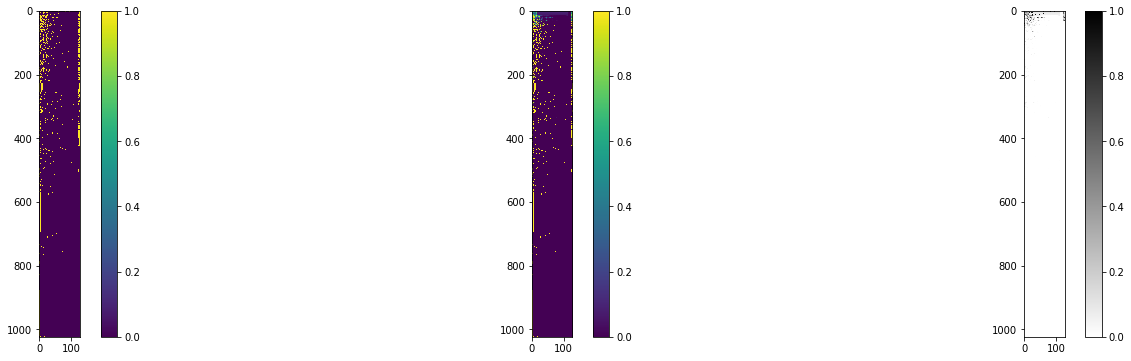

1.5581634e-08
0.987053


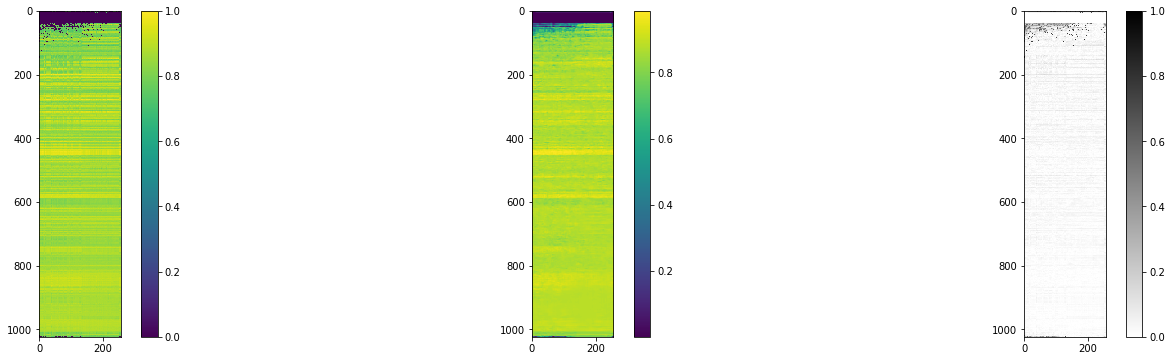

8.839629e-15
0.95211154


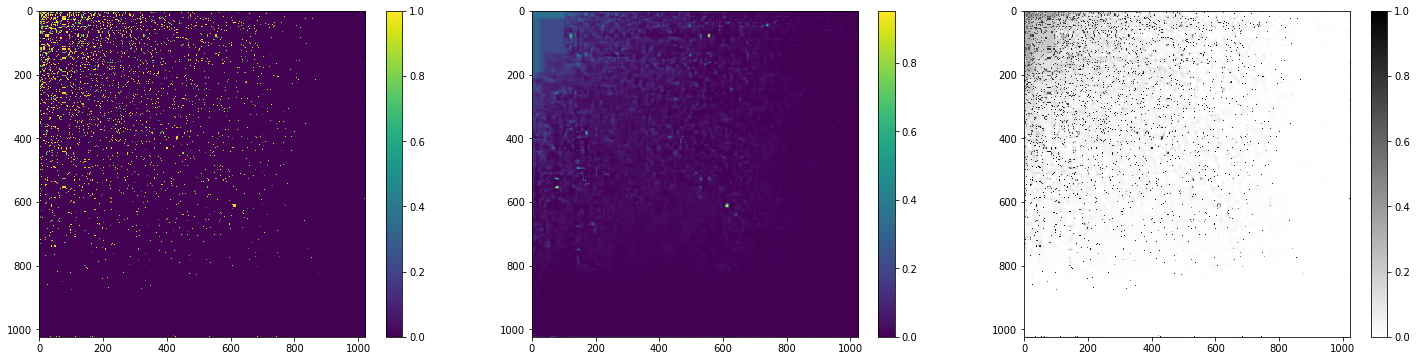

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_10/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


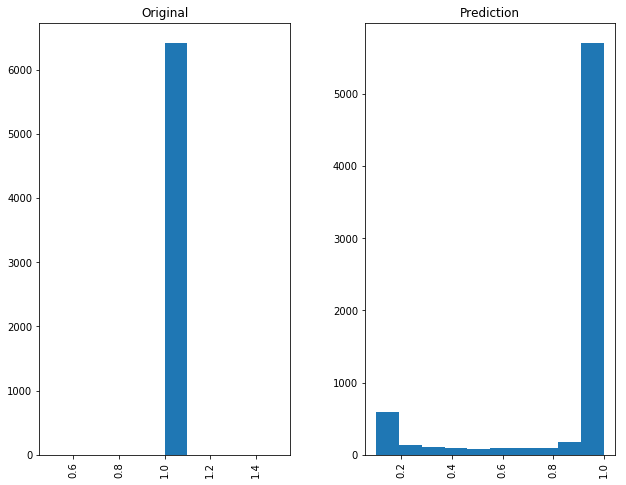

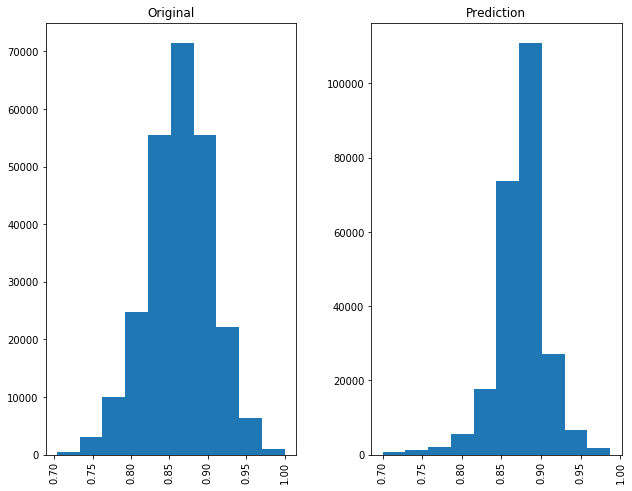

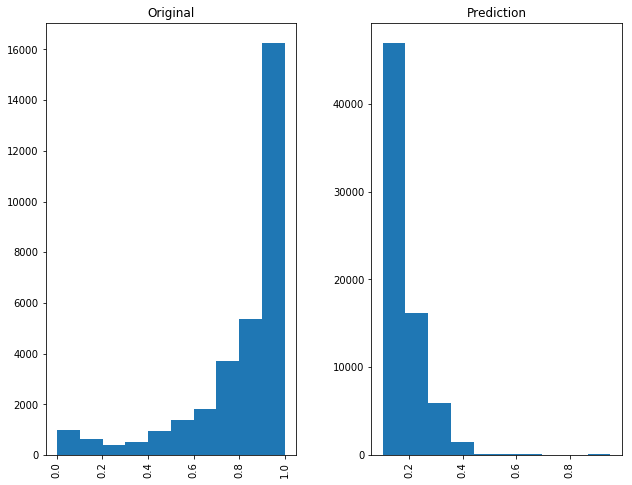

In [6]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


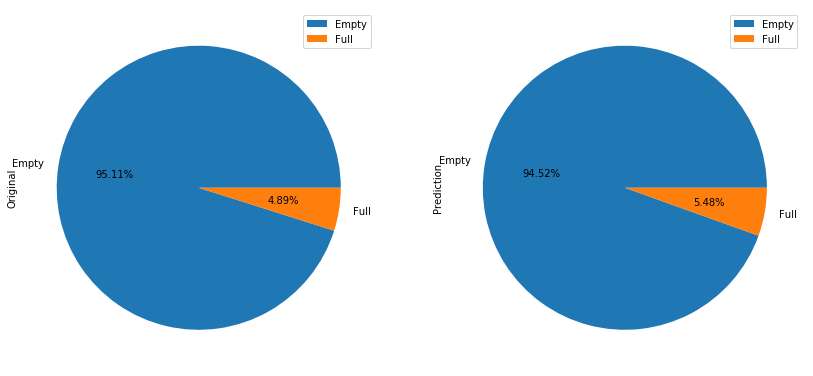

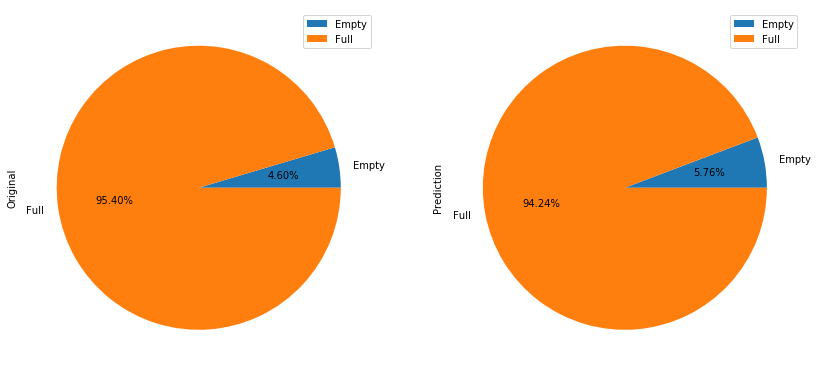

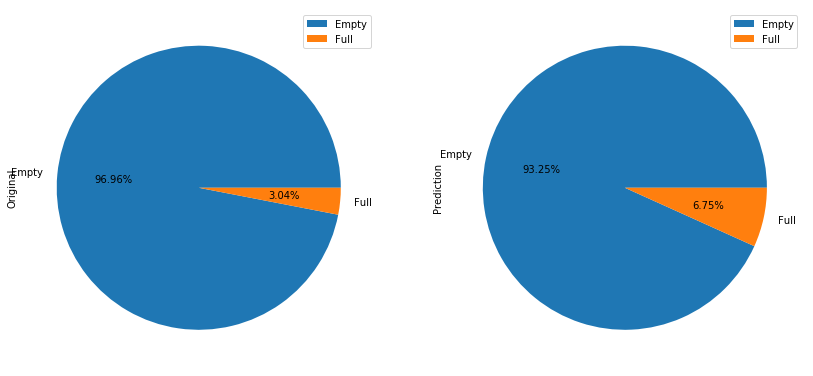

In [7]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.1]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

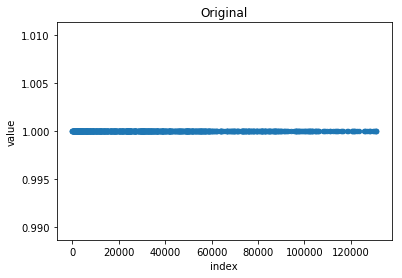

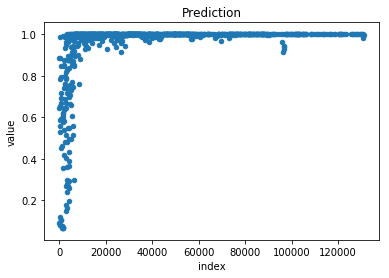

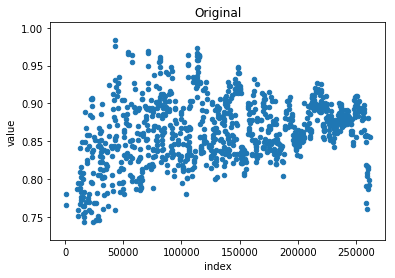

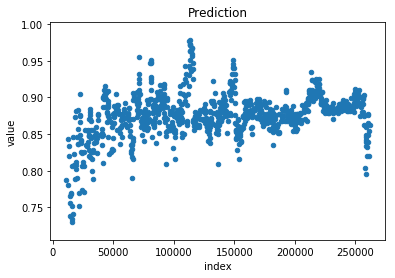

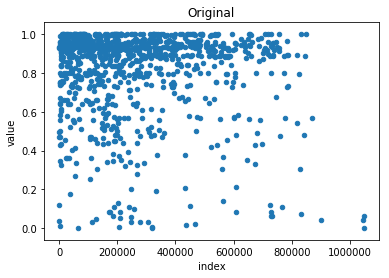

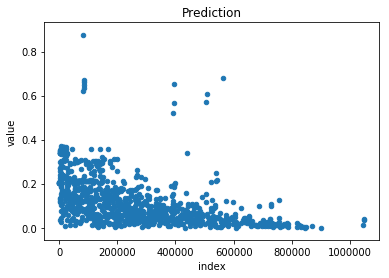

In [11]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['index', 'value'])
    df.plot.scatter(x='index', y='value', title='Original');

    df = pd.DataFrame(new_predict_data, columns=['index', 'value'])
    df.plot.scatter(x='index', y='value', title='Prediction');

    new_predict_data

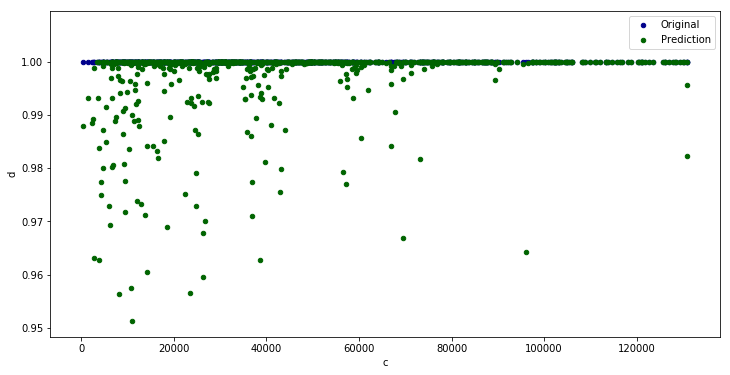

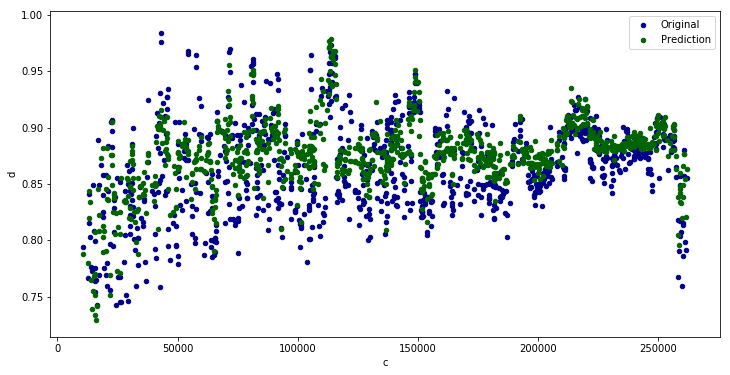

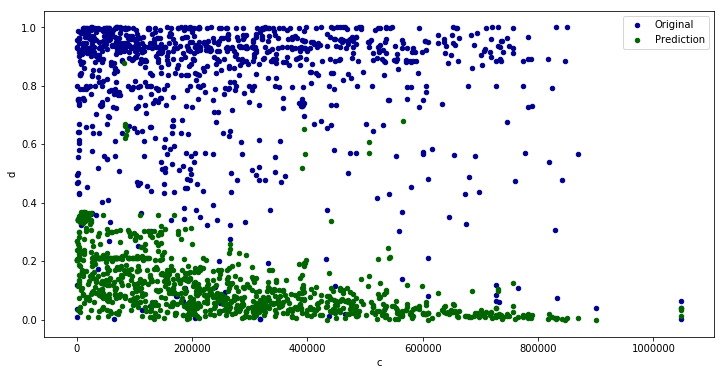

In [12]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'scatter_org_vs_prediction_' + str(i) + '.png')

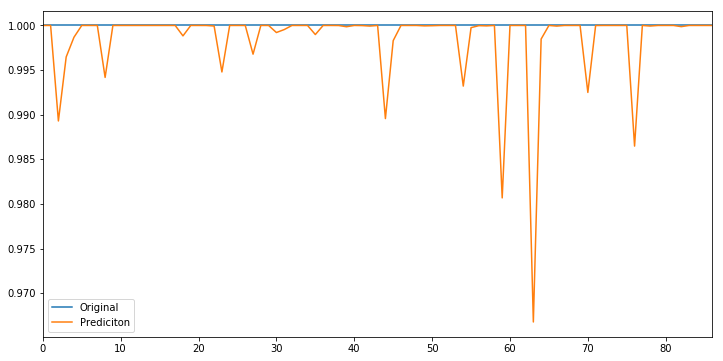

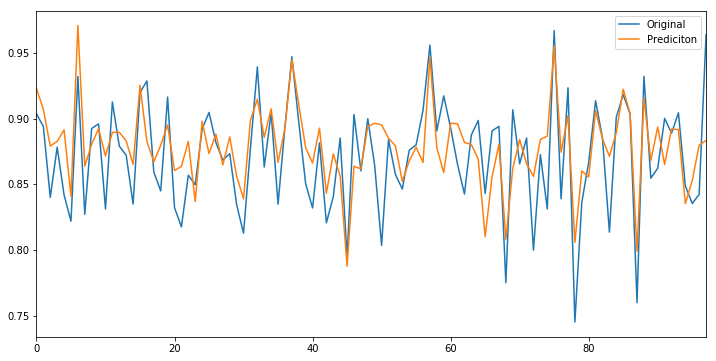

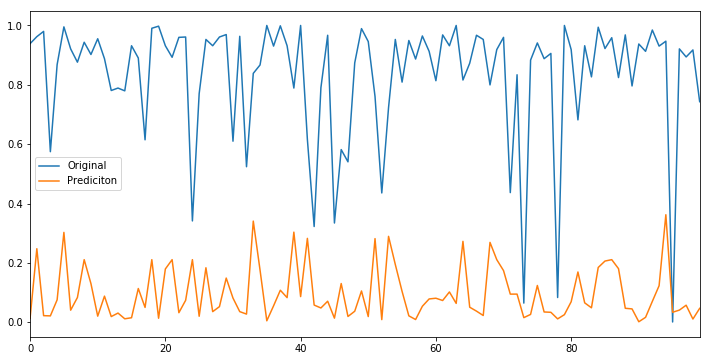

In [13]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][1], predict_data[j][1]])
        else:
            data.append([org_data[j][1], predict_data[j][1]])

    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    df.plot(subplots=False, figsize=(12,6), ax=ax)
    fig.savefig(path + 'graph_org_vs_prediction_' + str(i))